# Heterogeneity Analysis

I used [SCDE](http://hms-dbmi.github.io/scde/index.html) for the Differential Expression analysis between Stromal and Tumour cells

In [2]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
import pylab

In [3]:
%load_ext rpy2.ipython

In [6]:
%%R
library(scde)
library(ggplot2)
library(d3heatmap)
#library(made4)
library(ComplexHeatmap)
library(cowplot)

In [10]:
%%R
GeneName <- read.table("/home/baker/Rna-seq_Data-Analysis/Freya_Svedberg_Single_cell_analysis/mouse_gene_name.csv",sep=",",header=TRUE, row.names=1)
head(GeneName)

                      GeneName
ENSMUSG00000000001.4     Gnai3
ENSMUSG00000000003.12     Pbsn
ENSMUSG00000000028.11    Cdc45
ENSMUSG00000000031.12      H19
ENSMUSG00000000037.13    Scml2
ENSMUSG00000000049.8      Apoh


In [13]:
%%R
cdUntreated <- read.table("/home/baker/Rna-seq_Data-Analysis/Freya_Svedberg_Single_cell_analysis/UntreatedCountsFormatted.csv", sep=",",header=TRUE, row.names=1)
colnames(cdUntreated) <- paste0("Untr_C",c(1:96))
rownames(cdUntreated) <- make.names(GeneName$GeneName, unique=TRUE)
#colnames(cdStromal) <- sub("_.*", "_Stromal", colnames(cdStromal))
head(cdUntreated)

      Untr_C1 Untr_C2 Untr_C3 Untr_C4 Untr_C5 Untr_C6 Untr_C7 Untr_C8 Untr_C9
Gnai3       0       0       1       1      26       0      53       0       0
Pbsn        0       0       0       0       0       0       0       0       0
Cdc45       0       0       0       0       0       0       0       0       0
H19         0       0       0       0       0       0       0       0       0
Scml2       0       0       0       0       0       0       0       0       0
Apoh        0       0       0       0       0       0       0       0       0
      Untr_C10 Untr_C11 Untr_C12 Untr_C13 Untr_C14 Untr_C15 Untr_C16 Untr_C17
Gnai3        0        7        0       28       37        0      230        0
Pbsn         0        0        0        0        0        0        0        0
Cdc45        0        0        0        0        0        0        0        0
H19          0        0        0        0        0        0        0        0
Scml2        0        0        0        0        0        0     

## QC on Stromal Data

In [14]:
%%R
CV <- function(mean, sd){
      (sd/mean)^2
}

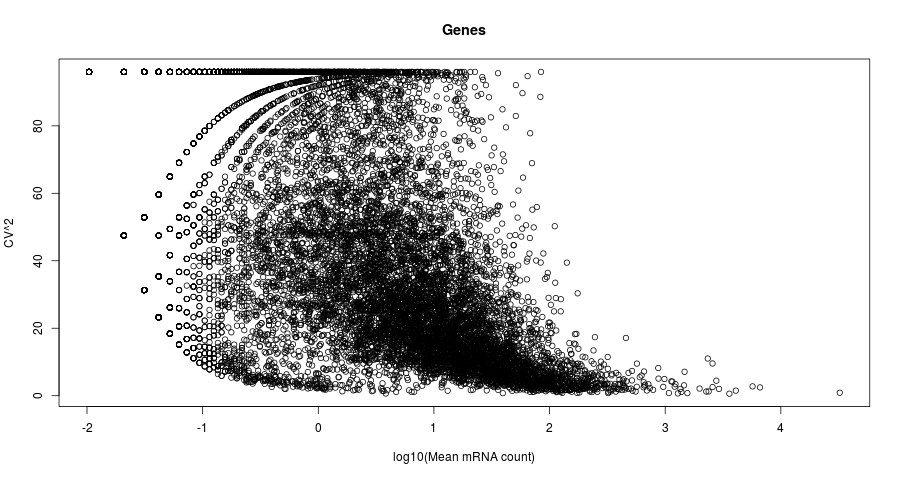

In [15]:
%%R -w 900
MeanAcrossGenes <- rowMeans(cdUntreated)
sdAcrossGenes <- apply(cdUntreated ,1,sd)
CVacrossGenes <- CV(MeanAcrossGenes, sdAcrossGenes)
df<-data.frame(LogMean=log10(MeanAcrossGenes),CVSquared=CVacrossGenes)
#print(head((MeanAcrossGenes)))
#p <- ggplot(df, aes_string(x="LogMean",y ="CVSquared"))
#print(p)
plot(log10(MeanAcrossGenes), CVacrossGenes, xlab='log10(Mean mRNA count)', ylab = 'CV^2', main='Genes')

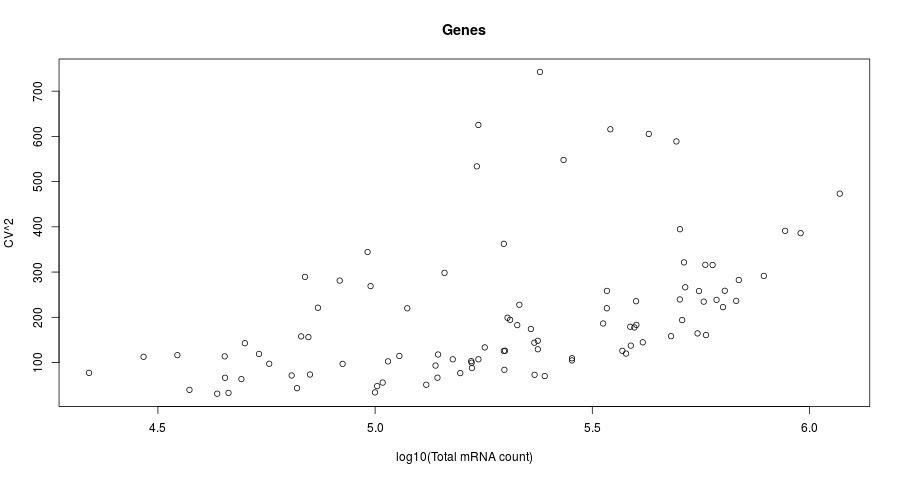

In [17]:
%%R -w 900
MeanAcrossCells <- colMeans(cdUntreated)
sdAcrossCells <- apply(cdUntreated,2,sd)
CVacrossCells <- CV(MeanAcrossCells, sdAcrossCells)
plot(log10(colSums(cdUntreated)), sdAcrossCells, xlab='log10(Total mRNA count)', ylab = 'CV^2', main='Genes')

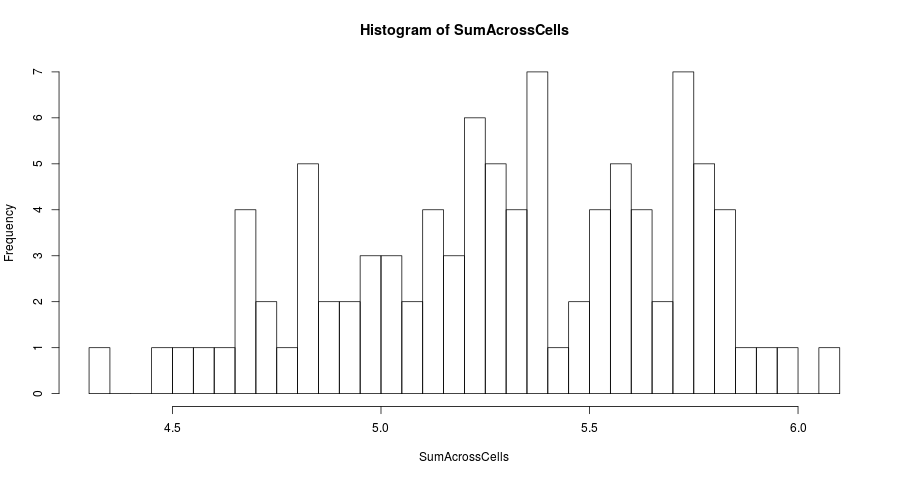

In [18]:
%%R -w 900
SumAcrossCells <- log10(colSums(cdUntreated))
hist(SumAcrossCells, breaks=50)

In [19]:
%%R
cdTreated <- read.table("/home/baker/Rna-seq_Data-Analysis/Freya_Svedberg_Single_cell_analysis/TreatedCountsFormatted.csv", sep=",",header=TRUE, row.names=1)
colnames(cdTreated) <- paste0("Treat_C",c(1:96))
rownames(cdTreated) <- make.names(GeneName$GeneName, unique=TRUE)
#colnames(cdTumour) <- sub("_.*", "_Tumour", colnames(cdTumour))
head(cdTreated)

      Treat_C1 Treat_C2 Treat_C3 Treat_C4 Treat_C5 Treat_C6 Treat_C7 Treat_C8
Gnai3        0        0       12        0        0        0        0      992
Pbsn         0        0        0        0        0        0        0        0
Cdc45       36        2        0        0        0        0        0        0
H19          0        0        0        0        0        0        0        0
Scml2        0        0        0        0        0        0        0        0
Apoh         0        0        0        0        0        0        0        0
      Treat_C9 Treat_C10 Treat_C11 Treat_C12 Treat_C13 Treat_C14 Treat_C15
Gnai3        4         0         0         0         0         0        24
Pbsn         0         0         0         0         0         0         0
Cdc45        0         0         0         0         0         0         0
H19          0         0         0         0         0         0         0
Scml2        0         0         0         0         0         0         0
Apoh

In [20]:
%%R
cdAll <- cbind(cdUntreated, cdTreated)
head(cdAll)

      Untr_C1 Untr_C2 Untr_C3 Untr_C4 Untr_C5 Untr_C6 Untr_C7 Untr_C8 Untr_C9
Gnai3       0       0       1       1      26       0      53       0       0
Pbsn        0       0       0       0       0       0       0       0       0
Cdc45       0       0       0       0       0       0       0       0       0
H19         0       0       0       0       0       0       0       0       0
Scml2       0       0       0       0       0       0       0       0       0
Apoh        0       0       0       0       0       0       0       0       0
      Untr_C10 Untr_C11 Untr_C12 Untr_C13 Untr_C14 Untr_C15 Untr_C16 Untr_C17
Gnai3        0        7        0       28       37        0      230        0
Pbsn         0        0        0        0        0        0        0        0
Cdc45        0        0        0        0        0        0        0        0
H19          0        0        0        0        0        0        0        0
Scml2        0        0        0        0        0        0     

In [21]:
%%R
# clean up the dataset
cdFiltered <- clean.counts(cdAll, min.lib.size=1000, min.reads = 10, min.detected = 5)
print(dim(cdFiltered))

[1] 9276  142


In [23]:
%%R
# factor determining cell types
sgFiltered <- factor(gsub("(Untr|Treat).*", "\\1", colnames(cdFiltered)), levels = c("Untr", "Treat"))
# the group factor should be named accordingly
names(sgFiltered) <- colnames(cdFiltered)
table(sgFiltered)

sgFiltered
 Untr Treat 
   68    74 


## Heterogeneity Analysis

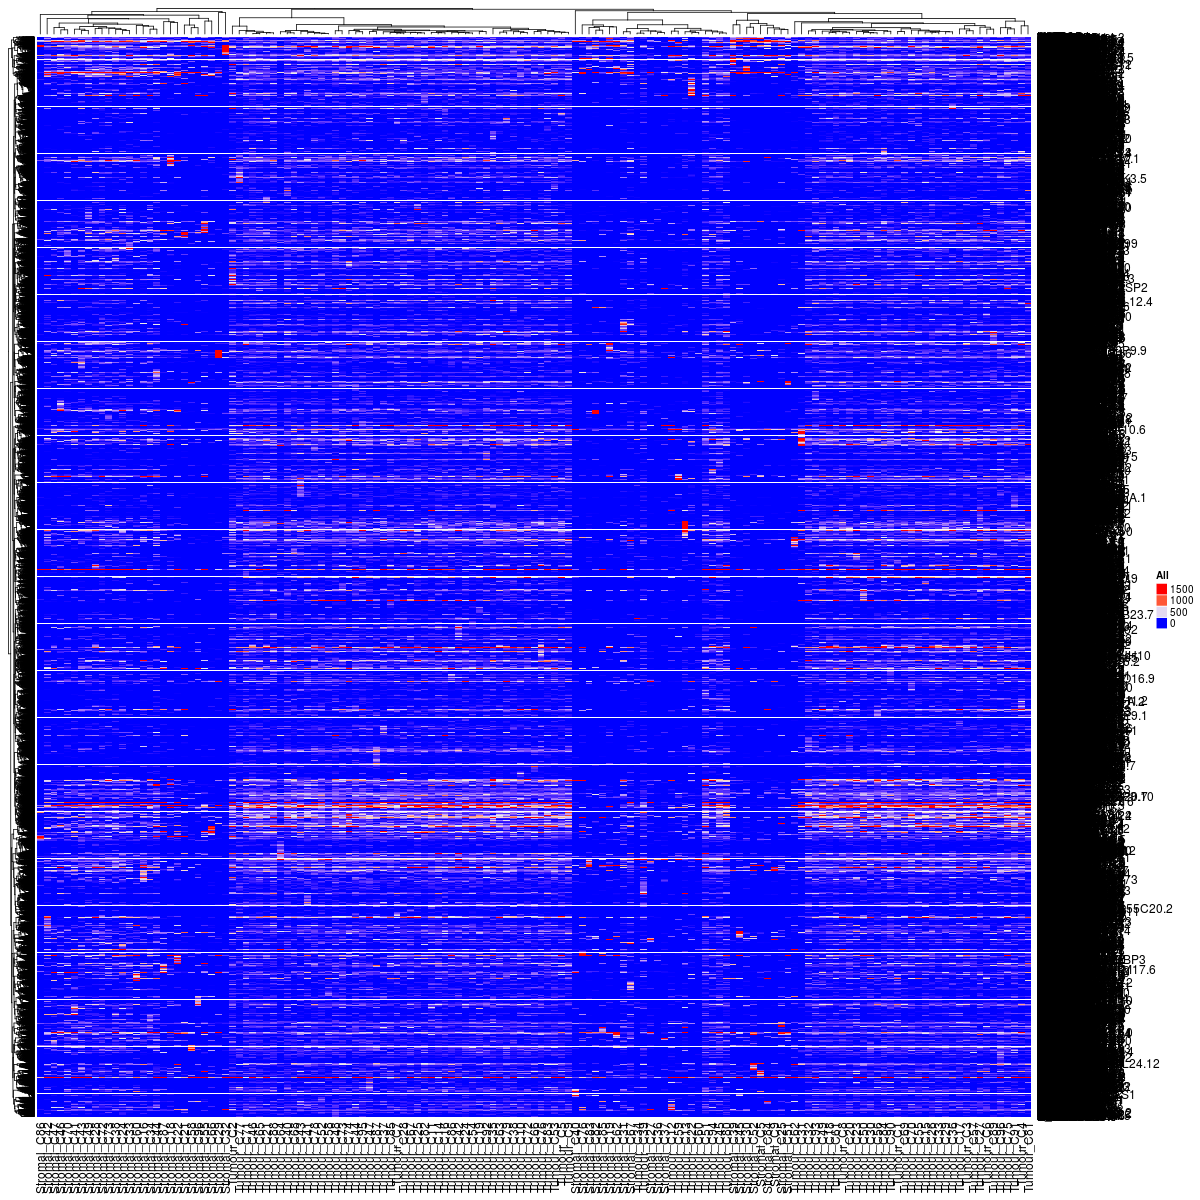

In [8]:
%%R -w 1200 -h 1200
#d3heatmap(NormalizedCount, scale = "column", dendrogram = "none", color = "Blues")
#heatmap.2(NormalizedCount, Rowv=NA, Colv=NA, col = cm.colors(256), scale="column", margins=c(5,10))
#sTree <- heatplot(NormalizedCount, dend="both", dualScale=FALSE, scale="row", cexRow=0.8, cexCol=0.8, returnSampleTree=TRUE)
#class(sTree)
df = data.frame(type = c(rep("Stromal", 49), rep("Tumour", 96)))
ha = HeatmapAnnotation(df = df, col = list(type = c("Stromal" =  "red", "Tumour" = "blue")))
ha
scaledNormalizedCount <- scale(NormalizedCount)
# ht1 = Heatmap(scaledNormalizedCount, name="All", cluster_rows =F, cluster_columns = T, show_column_dend = T, show_row_dend=F, clustering_distance_column="pearson", column_names_gp = gpar(fontsize = 8), show_row_names = FALSE, column_dend_height = unit(14, "mm"), top_annotation = ha)
ht1 = Heatmap(NormalizedCount, name="All", cluster_rows =F, cluster_columns = T, show_column_dend = T, show_row_dend=F, clustering_distance_column="pearson", column_names_gp = gpar(fontsize = 8), show_row_names = FALSE, column_dend_height = unit(14, "mm"), top_annotation = ha)
print(ht1)

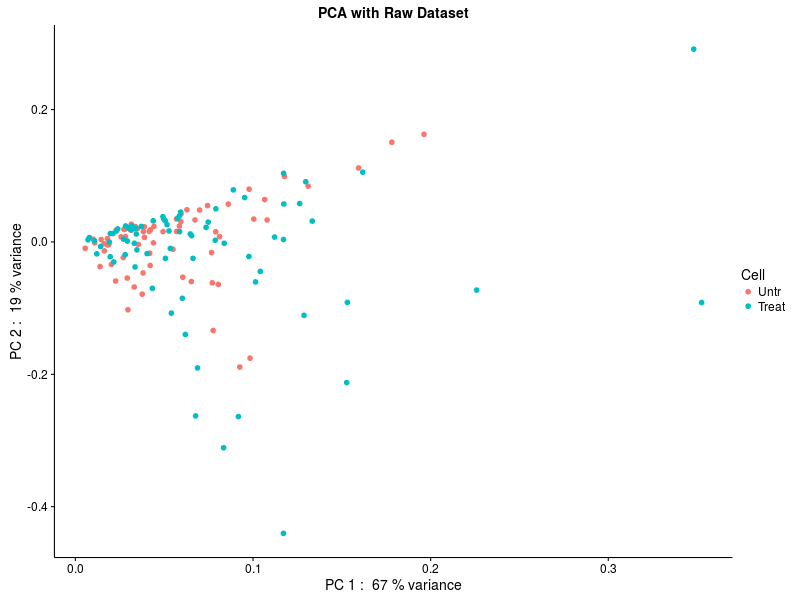

In [24]:
%%R -w 800 -h 600
FinalPCAData <- cdFiltered
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
sampleCondition <- c(rep("Untr",68), rep("Treat",74))
strain <- factor(sampleCondition, levels=c("Untr", "Treat"),labels=c("Untr", "Treat"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p2<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p2<-p2+ggtitle("PCA with Raw Dataset")
p2<-p2+geom_point(size = 2)
p2<-p2+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p2<-p2    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=2, vjust=1,hjust=0.5,angle=45, color="black")
print(p2)

Only Untreated and Treated ones

In [25]:
%%R
colnames(cdFiltered[1:68])

 [1] "Untr_C1"  "Untr_C3"  "Untr_C4"  "Untr_C5"  "Untr_C7"  "Untr_C9" 
 [7] "Untr_C10" "Untr_C12" "Untr_C13" "Untr_C14" "Untr_C15" "Untr_C16"
[13] "Untr_C20" "Untr_C21" "Untr_C22" "Untr_C23" "Untr_C26" "Untr_C27"
[19] "Untr_C29" "Untr_C30" "Untr_C31" "Untr_C33" "Untr_C34" "Untr_C35"
[25] "Untr_C36" "Untr_C37" "Untr_C43" "Untr_C44" "Untr_C45" "Untr_C48"
[31] "Untr_C50" "Untr_C51" "Untr_C52" "Untr_C55" "Untr_C56" "Untr_C57"
[37] "Untr_C59" "Untr_C60" "Untr_C61" "Untr_C62" "Untr_C63" "Untr_C64"
[43] "Untr_C65" "Untr_C66" "Untr_C67" "Untr_C68" "Untr_C69" "Untr_C70"
[49] "Untr_C73" "Untr_C74" "Untr_C75" "Untr_C76" "Untr_C77" "Untr_C78"
[55] "Untr_C80" "Untr_C81" "Untr_C82" "Untr_C83" "Untr_C84" "Untr_C86"
[61] "Untr_C87" "Untr_C88" "Untr_C89" "Untr_C91" "Untr_C93" "Untr_C94"
[67] "Untr_C95" "Untr_C96"


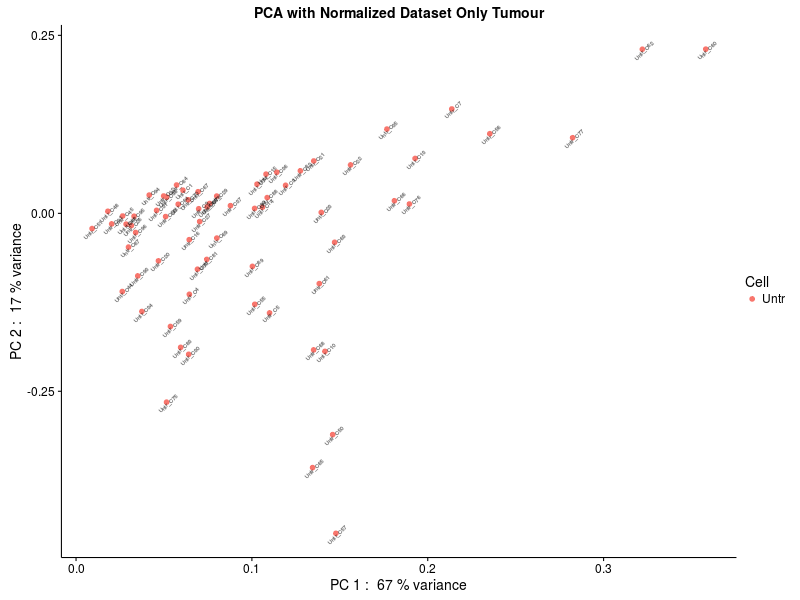

In [26]:
%%R -w 800 -h 600
FinalPCAData <- cdFiltered[,1:68]
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
sampleCondition <- c(rep("Untr",68))
strain <- factor(sampleCondition, levels=c("Untr"),labels=c("Untr"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p3<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p3<-p3+ggtitle("PCA with Normalized Dataset Only Tumour")
p3<-p3+geom_point(size = 2)
p3<-p3+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p3<-p3    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p3<-p3 + geom_text(data=df,aes(label=colnames(cdFiltered[1:68])),alpha=0.5,size=2, vjust=1,hjust=0.5,angle=45, color="black")
print(p3)

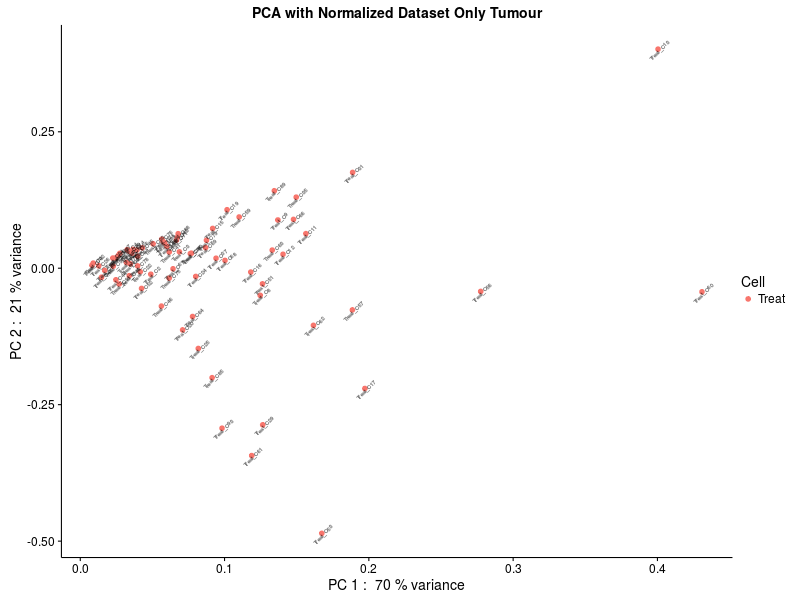

In [27]:
%%R -w 800 -h 600
FinalPCAData <- cdFiltered[,69:dim(cdFiltered)[2]]
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
sampleCondition <- c(rep("Treat",74))
strain <- factor(sampleCondition, levels=c("Treat"),labels=c("Treat"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p3<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p3<-p3+ggtitle("PCA with Normalized Dataset Only Tumour")
p3<-p3+geom_point(size = 2)
p3<-p3+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p3<-p3    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p3<-p3 + geom_text(data=df,aes(label=colnames(cdFiltered[,69:dim(cdFiltered)[2]])),alpha=0.5,size=2, vjust=1,hjust=0.5,angle=45, color="black")
print(p3)